<br><br>
<h1 align="center"> 02 Initial EDS </h1>
<h4 align="center"> ( Basic Data Visualization ) </h4>
<br><br>

In [1]:
'''import thpe libraries'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

In [2]:
'''load the data. It's big, set low_memory=False'''
loan_data = pd.read_csv('/opt/apps/ml-data/bigdata/lending_club/loan_data.csv', low_memory=False)

In [3]:
'''How many rows and columns?'''
print(loan_data.shape)

(1340973, 38)


In [6]:
'''
The data is cleaned up and ready now for EDA.
Missing values are filled in with values (mean, median, zeros etc.)
'''
cols = loan_data.columns
null_count = 0
null_pct = 'None'
d = []
d_types = loan_data.dtypes

for ind, col in enumerate(cols):
    null_count = loan_data[col].isnull().sum()
    if null_count > 0:
        null_pct = 'Missing Values'
    else:
        null_pct = 'None'
    

    d.append({'col': col, 'null_count': null_count, 'null_pct': null_pct, 'd_type': d_types[col], 
              'n_unique': loan_data[col].nunique()})
    null_count = 0
    null_pct = 'None'
    
    
loan_data_info = pd.DataFrame(d)

loan_data_info['null_pct'].value_counts()

None    38
Name: null_pct, dtype: int64

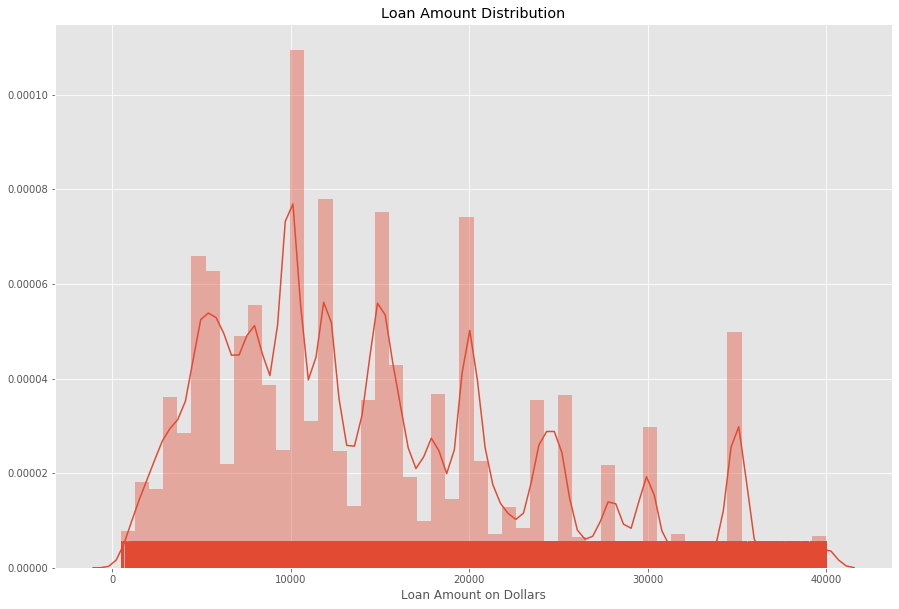

In [7]:
'''Loan Amount Distribution'''
plt.style.use('ggplot')
plt.figure(figsize=(15, 10))

sns.distplot(loan_data['loan_amnt'], rug=True)

plt.xlabel("Loan Amount on Dollars")
plt.title("Loan Amount Distribution")

plt.show()

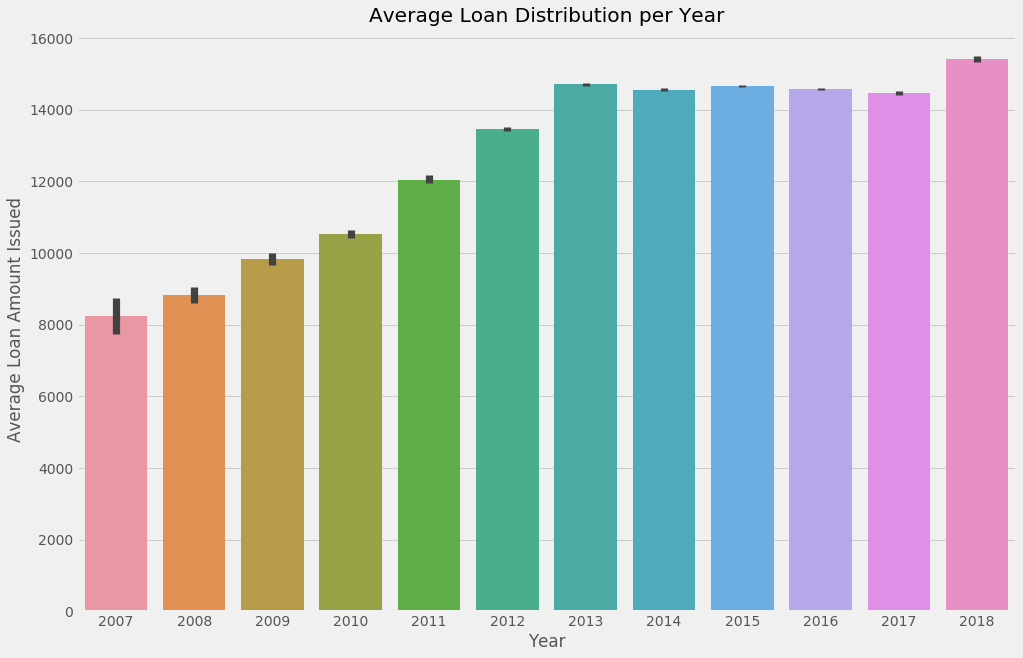

In [8]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))

loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'])
sns.barplot(loan_data['issue_d'].dt.year, 'loan_amnt', data=loan_data)

plt.title('Average Loan Distribution per Year')
plt.xlabel('Year')
plt.ylabel('Average Loan Amount Issued')

plt.show()

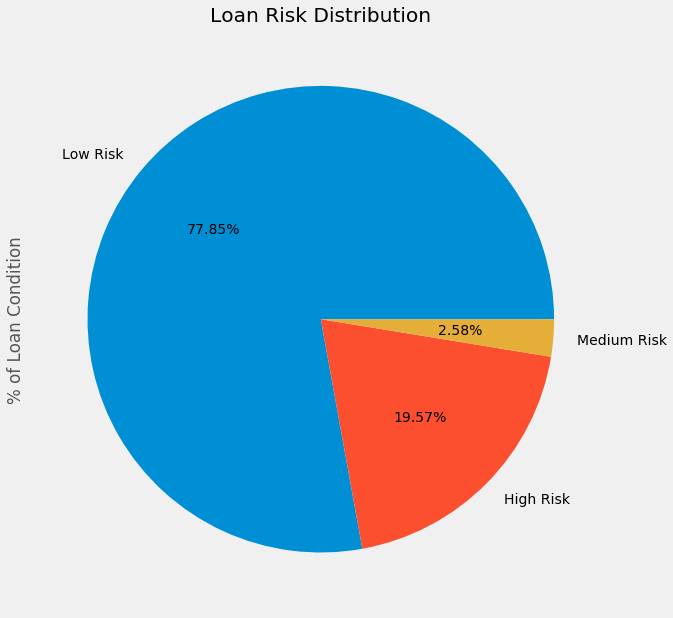

In [9]:
plt.figure(figsize=(15, 10))

risk_counts = loan_data['risk'].value_counts()
risk_counts.plot.pie(autopct='%1.2f%%')

plt.title('Loan Risk Distribution (part - whole)')
plt.xlabel('')
plt.ylabel('% of Loan Condition')

plt.show()

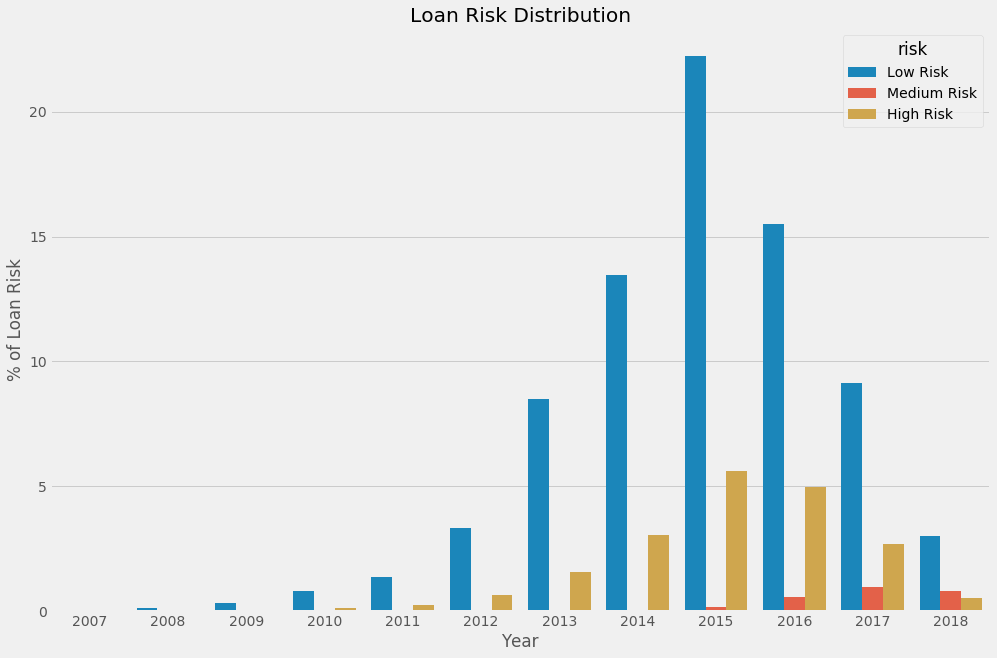

In [10]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))

sns.barplot(x=loan_data['issue_d'].dt.year, y="loan_amnt", 
            hue="risk", data=loan_data, 
            estimator=lambda x: len(x) / len(loan_data) * 100)

plt.title('Loan Risk Distribution per Year')
plt.xlabel('Year')
plt.ylabel('% of Loan Risk')

plt.show()

In [9]:
loan_data['addr_state'].unique()

'''Make a list with each of the regions by state.'''
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']


loan_data['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'South West'
    elif state in south_east:
        return 'South East'
    elif state in mid_west:
        return 'Mid West'
    elif state in north_east:
        return 'North East'


loan_data['region'] = loan_data['addr_state'].apply(finding_regions)
loan_data['region'].value_counts()

South East    324228
West          319059
North East    302534
Mid West      233225
South West    161927
Name: region, dtype: int64

In [10]:
by_loan_amount = loan_data.groupby(['region','addr_state'], as_index=False).loan_amnt.sum()
by_interest_rate = loan_data.groupby(['region', 'addr_state'], as_index=False).int_rate.mean()
by_income = loan_data.groupby(['region', 'addr_state'], as_index=False).annual_inc.mean()

'''Take the values to a list for visualization purposes.'''
states = by_loan_amount['addr_state'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amnt'].values.tolist()
average_interest_rates = by_interest_rate['int_rate'].values.tolist()
average_annual_income = by_income['annual_inc'].values.tolist()


from collections import OrderedDict

metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates),
                            ('annual_income', average_annual_income)])
                     

metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()

,state_codes,issued_loans,interest_rate,annual_income
0,IA,114075,12.63,44756.21
1,IL,757873225,13.15,77943.09
2,IN,303733925,13.47,68986.51
3,KS,157123425,13.20,69771.31
4,MI,485811550,13.43,70058.66


In [17]:
'''Now it comes the part where we plot out plotly United States map'''
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot


for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)
    
scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['interest_rate'] + '<br>'+\
'Average annual income: ' + metrics_df['annual_income'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'], 
        locationmode = 'USA-states',
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]


layout = dict(
    title = 'Geographical Distribution of Loans',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

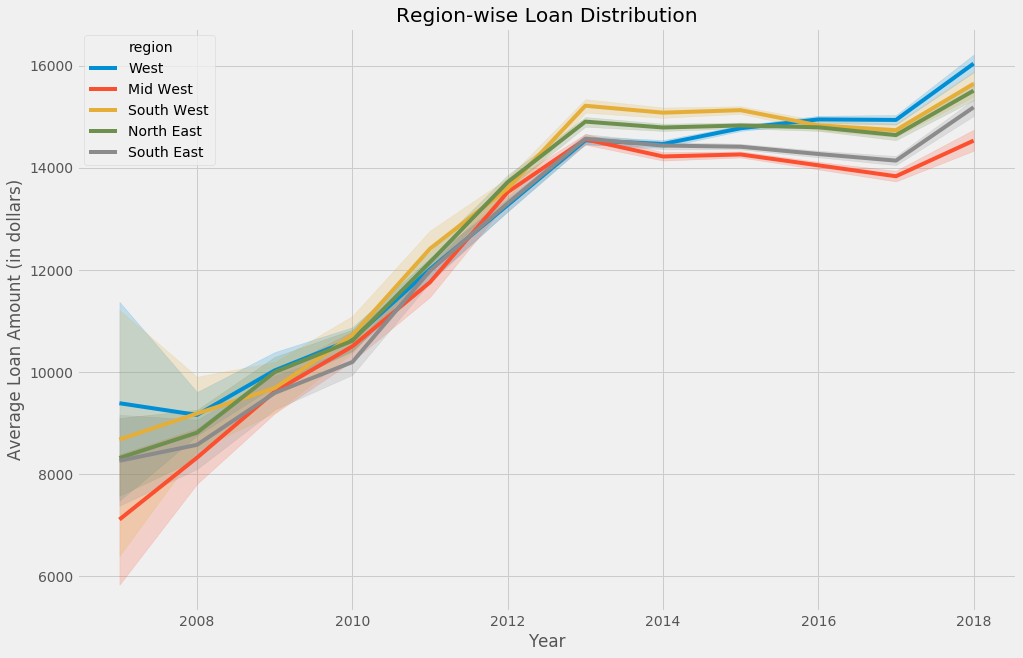

In [12]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))

sns.lineplot(x=loan_data['issue_d'].dt.year, y="loan_amnt", hue="region", data=loan_data)

plt.title('Region-wise Loan Distribution')
plt.xlabel('Year')
plt.ylabel('Average Loan Amount (in dollars)')

plt.show()

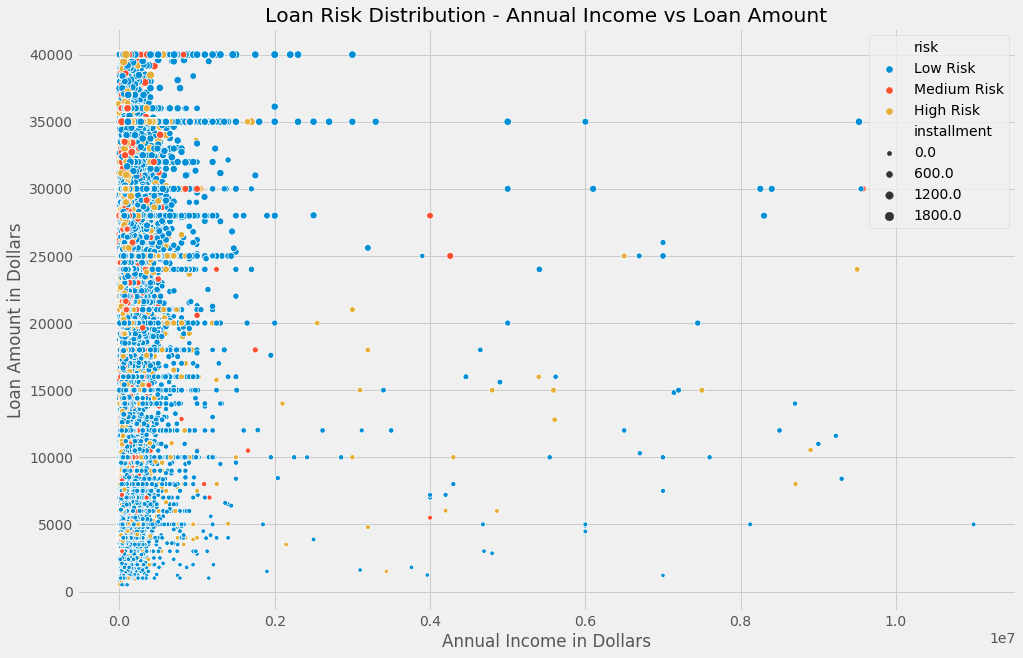

In [16]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))

sns.scatterplot(x='annual_inc', y="loan_amnt", hue="risk", size='installment', data=loan_data)

plt.title('Loan Risk Distribution - Annual Income vs Loan Amount')
plt.xlabel('Annual Income in Dollars')
plt.ylabel('Loan Amount in Dollars')

plt.show()

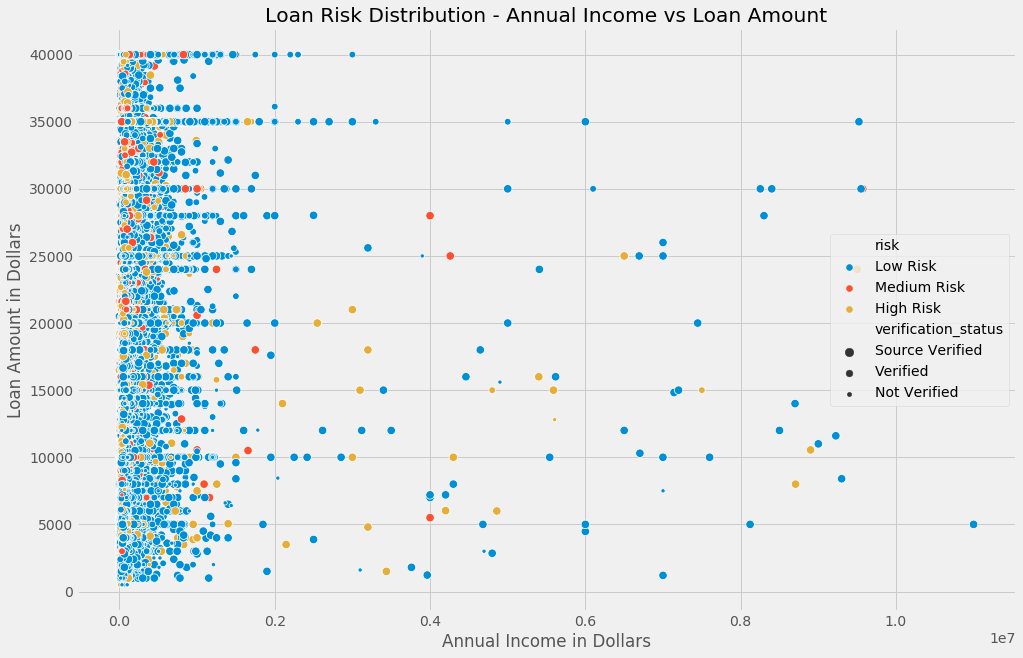

In [18]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))

sns.scatterplot(x='annual_inc', y="loan_amnt", hue="risk", size='verification_status', data=loan_data)

plt.title('Loan Risk Distribution - Annual Income vs Loan Amount')
plt.xlabel('Annual Income in Dollars')
plt.ylabel('Loan Amount in Dollars')

plt.show()

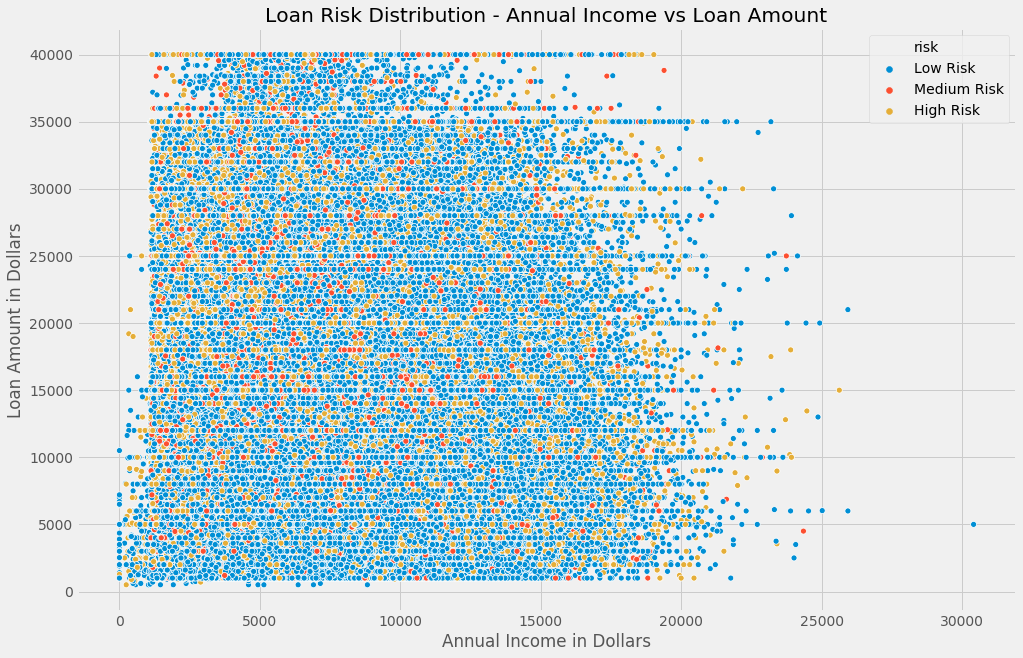

In [19]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))

sns.scatterplot(x='age_of_credit_in_days', y="loan_amnt", hue="risk", data=loan_data)

plt.title('Loan Risk Distribution - Annual Income vs Loan Amount')
plt.xlabel('Annual Income in Dollars')
plt.ylabel('Loan Amount in Dollars')

plt.show()